In [258]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [259]:
class CDM:
    def __init__(self, h):
        self.h = h
    
    def diff(self, f, x):
        numerator = f(x + self.h) - f(x - self.h)
        denominator = 2 * self.h

        return numerator / denominator

In [260]:
class Newton:
    def __init__(self, f, CDM_object, tol=1e-6, max_iter=1000):
        self.f = f
        self.CDM = CDM_object
        self.tol = tol 
        self.max_iter = max_iter

    def solve(self, y, x0):
        x = x0
        for _ in range(self.max_iter):
            f_x = self.f(x) - y
            f_prime_x = self.CDM.diff(self.f, x)
            if abs(f_prime_x) < 1e-10:
                raise ValueError("Derivative is zero, method fails.")
            x_new = x - f_x / f_prime_x
            if abs(x_new - x) < self.tol:
                return x_new
            x = x_new

        raise ValueError(f"Method did not converge.({x_new})")

In [261]:
class LCG:
    def __init__(self, seed, a=561860773102413563, c=0, m=2**60-93):
        self.seed = seed
        self.a = a
        self.c = c
        self.m = m
        self.state = seed

    def next(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state / self.m  # Normalize to [0, 1)
    
    def next_in_range(self, a, b):
        return a + (b - a) * self.next()

In [262]:
class MonteCarlo:
    def __init__(self, N, PRNG_object):
        self.N = int(N)
        self.PRNG = PRNG_object
    
    def integrate(self, f, a, b):
        mult = (b - a) / self.N

        generatedValues = []
        for _ in range(self.N):
            randomArg = self.PRNG.next_in_range(a, b)
            randomFuncVal = f(randomArg)

            generatedValues.append(randomFuncVal)
        
        return mult * sum(generatedValues)


In [263]:
import scipy.special
import numpy as np

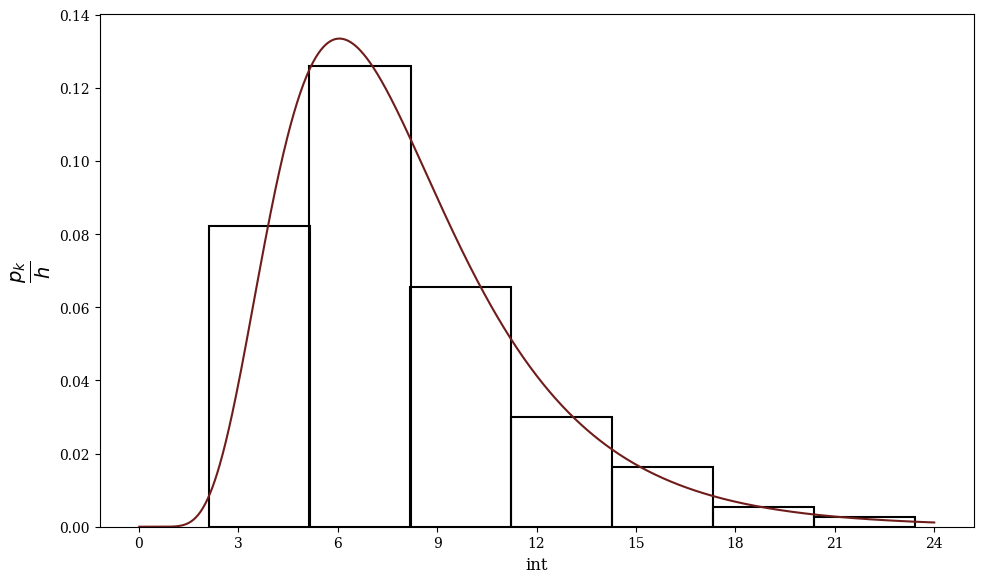

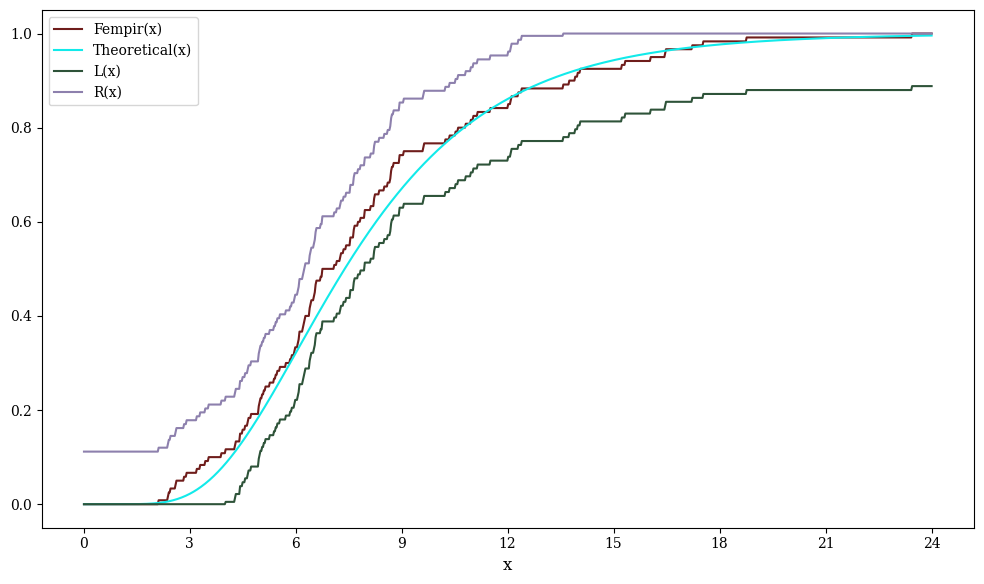

In [264]:
if __name__ == '__main__':

    # -------------------------------PART1-------------------------------

    def cdf(x): # F_X
        return float(1/2 + 1/2 * \
            scipy.special.erf((np.log(x) - 2)/(np.sqrt(0.4))))

    cdm    = CDM(h=1e-6)
    newton = Newton(cdf, cdm, tol=1e-6, max_iter=1000)

    def inverse(y, x0): # x = f^-1(y)
        return newton.solve(y, x0)

    n = 120

    lcg = LCG(seed=340751464)

    # -------------------------------PART2-------------------------------

    data = [lcg.next() for _ in range(n)]
    # print(f'Y: {data}')

    guesses = [0, 3, 6, 9, 12, 15, 18, 21]
    for ind, el in enumerate(data):
        for attempt, guess in enumerate(guesses):
            try: 
                inv_value = inverse(el, guess)
                data[ind] = inv_value
                break
            except:
                pass

            if attempt == len(guesses) - 1:
                raise Exception('Solution was not found')
    
    # print(f'X: {data}')

    # -------------------------------PART3-------------------------------

    mini, maxi = min(data), max(data)
    # print(f'min: {mini}, max: {maxi}')

    range_ = maxi - mini
    # print(f'range: {range_}')

    # -------------------------------PART4-------------------------------

    trunc = lambda x : int(str(x)[:str(x).index('.')])

    k = 1 + trunc(np.log2(n))
    # print(f'k: {k}')
    
    h = range_ / k
    # print(f'h: {h}')

    # -------------------------------PART5-------------------------------

    grouped_data = []

    begin = mini
    for i in range(k):
        end = begin + h

        middle = (begin + end) / 2
        freq = sum(begin <= el < end for el in data)
        
        if i == k - 1:
            freq += 1

        relative_freq = freq / n

        grouped_element = {
            'interval numero': i,
            'interval': f'[{np.round(begin, 4)}, {np.round(end, 4)})',
            'middle': np.round(middle, 4),
            'frequency': freq,
            'relative frequency': relative_freq
        }
        grouped_data.append(grouped_element)

        begin = end

    # for element in grouped_data:
    #     print(element['interval numero'], 
    #           element['interval'], 
    #           element['middle'], 
    #           element['frequency'], 
    #           element['relative frequency'])

    # -------------------------------PART6-------------------------------

    import matplotlib.pyplot as plt

    def pdf(x):
        return 1 / (np.sqrt(0.4 * np.pi) * x) \
            * np.exp(-(np.log(x) - 2)**2 / 0.4)

    def buildBar(x, y):
        # Define colors
        RED   = '#6F1D1B'

        # Define font sizes
        SIZE_TICKS   = 10

        # Create the figure and axis
        _, ax = plt.subplots(figsize=(10, 6))

        # histogramm
        ax.bar(x, y, width=3.05, color='none', 
                                 edgecolor='black', 
                                 linewidth=1.5)

        # pdf
        x_values = np.linspace(0.01, trunc(maxi) + 1, 1000)
        y_values = pdf(x_values)
        ax.plot(x_values, y_values, color=RED, 
                                    linestyle='-', 
                                    linewidth=1.5)

        # axis names
        ax.set_xlabel('int')
        ax.set_ylabel('$\\frac{p_k}{h}$', fontsize=20)

        # ticks settings
        xticks = [i for i in range(0, trunc(maxi) + 2, 3)]
        ax.set_xticks(xticks)

        # Adjust the font size of the tick labels
        ax.tick_params(axis='both', which='major', 
                                    labelsize=SIZE_TICKS)

        # Update font settings
        plt.rcParams.update({'font.family': 'serif', 
                             'font.size': 12})

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        # plt.savefig('histXpdf.png', dpi=300, transparent=True)

        # Show the plot
        plt.show()

    x_axis = [el['middle']                 for el in grouped_data]
    y_axis = [el['relative frequency'] / h for el in grouped_data]

    # print(f'x: {np.round(x_axis, 4)}')
    # print(f'y: {np.round(y_axis, 4)}')

    buildBar(x_axis, y_axis)

    # -------------------------------PART7-------------------------------

    monteCarlo = MonteCarlo(1e7, lcg)

    def subs(t):
        return np.tan(t) * pdf(np.tan(t)) * (1 / np.cos(t)**2) 

    ExpectedValue = monteCarlo.integrate(subs, 0, np.pi/2)

    # print(ExpectedValue)

    # -------------------------------PART8-------------------------------

    def subs2(t):
        return np.tan(t)**2 * pdf(np.tan(t)) * (1 / np.cos(t)**2) 

    Var = monteCarlo.integrate(subs2, 0, np.pi/2) - \
          monteCarlo.integrate(subs, 0, np.pi/2)**2
    
    # print(Var)

    # -------------------------------PART9-------------------------------

    OverlineX = sum(data)/n

    # print(f'OverlineX: {OverlineX}')

    S2 = 1 / (n - 1) * sum([(x - OverlineX)**2 for x in data])

    # print(f'S2: {S2}')

    # -------------------------------PART10-------------------------------

    diff1 = abs(ExpectedValue - OverlineX)
    diff2 = np.sqrt(Var/S2)

    # print(diff1)
    # print(diff2)

    # -------------------------------PART11-------------------------------

    def Fempir(x):
        ind = lambda x : 1 if x > 0 else 0

        return sum([ind(x - X)/n for X in data])

    alpha = 0.1
    epsilon = np.sqrt(1/(2*n) * np.log(2/alpha))

    def L(x):
        return max(Fempir(x) - epsilon, 0)
    
    def R(x):
        return min(Fempir(x) + epsilon, 1)
    
    # -------------------------------PART12-------------------------------

    def buildPlots():
        # Define colors
        RED    = '#6F1D1B'
        BLUE   = '#12EAEA'
        GREEN  = '#2E5339'
        PURPLE = '#8D80AD'

        # Define font sizes
        SIZE_TICKS   = 10

        # Create the figure and axis
        _, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

        x_values = np.linspace(0.01, trunc(maxi) + 1, 1000)

        # empir
        empir_y_values = [Fempir(x) for x in x_values]
        ax.plot(x_values, empir_y_values, color=RED, 
                                          linestyle='-', 
                                          linewidth=1.5, 
                                          label='Fempir(x)')

        # theoretical
        cdf_y_values = [cdf(x) for x in x_values]
        ax.plot(x_values, cdf_y_values, color=BLUE, 
                                          linestyle='-', 
                                          linewidth=1.5, 
                                          label='Theoretical(x)')

        # L
        L_y_values = [L(x) for x in x_values]
        ax.plot(x_values, L_y_values, color=GREEN, 
                                          linestyle='-', 
                                          linewidth=1.5, 
                                          label='L(x)')

        # R
        R_y_values = [R(x) for x in x_values]
        ax.plot(x_values, R_y_values, color=PURPLE, 
                                          linestyle='-', 
                                          linewidth=1.5, 
                                          label='R(x)')

        # axis names
        ax.set_xlabel('x')

        # ticks settings
        xticks = [i for i in range(0, trunc(maxi) + 2, 3)]
        ax.set_xticks(xticks)

        # Adjust the font size of the tick labels
        ax.tick_params(axis='both', which='major', 
                                    labelsize=SIZE_TICKS)

        plt.legend(fontsize=10, loc='best')

        # Update font settings
        plt.rcParams.update({'font.family': 'serif', 
                             'font.size': 12})

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        # plt.savefig('Dvoretzky-Kiefer-Wolfowitz.png', 
        #             dpi=300, transparent=True)

        # Show the plot
        plt.show()

    buildPlots()

<center> <h> TESTING </h> </center>

In [265]:
1e6

1000000.0

In [266]:
from scipy.stats import lognorm

mu = 2
sigma = np.sqrt(0.2)

lognorm_dist = lognorm(s=sigma, scale=np.exp(mu))

def foo(x):
    # return math.sin(x)
    # return x**3 - 2 * x - 5
    return lognorm_dist.cdf(x)

def inv_foo(y):
    return lognorm_dist.ppf(y)


In [267]:
if __name__ == '__main__':
    def cdf(x): # F_X
        return 1/2 + 1/2 * scipy.special.erf((np.log(x) - 2)/(np.sqrt(0.4)))

    for i in range(0, 15):
        print(f'{foo(i)}   {cdf(i)}')

    cdm    = CDM(h=1e-6)
    newton = Newton(cdf, cdm, tol=1e-6, max_iter=1000)

    def inverse(y, x0): # x = f^-1(y)
        return newton.solve(y, x0)

    print(f'')

    data    = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    guesses = [0, 3, 6, 9, 12, 15]

    for el in data:
        print(f'scipy: {inv_foo(el)}')
        for guess in guesses:
            try: 
                print(f'mine: {newton.solve(el, guess)}')
                break
            except:
                print(f'guess {guess} did not converge') 
        print('-'*200)

0.0   0.0
3.872108215522035e-06   3.8721082155079856e-06
0.0017377758616781594   0.0017377758616781702
0.02192278341298803   0.02192278341298809
0.08498697353639512   0.08498697353639517
0.1912434209910377   0.1912434209910377
0.32073660943851223   0.32073660943851223
0.4518658802235498   0.45186588022354973
0.5704958448352845   0.5704958448352841
0.6703962386690854   0.6703962386690855
0.7506703760137534   0.7506703760137536
0.8131921096796417   0.8131921096796417
0.8608806027417297   0.8608806027417297
0.8967530500020445   0.8967530500020444
0.9234943810897667   0.9234943810897667

scipy: 4.165651627465189
guess 0 did not converge
mine: 4.165651627465252
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
scipy: 5.071393044464941
guess 0 did not converge
mine: 5.07139304446494
-------------------------------------------------------------